In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
import scipy.stats
import datetime as dt
import pydot
import warnings

warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Embedding, LeakyReLU, concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

In [4]:
df = pd.read_csv('./Covid-19-Patient-Health-Analytics-master/cvd/data.csv')  
df = df.drop('id',axis=1)  
df = df.fillna(np.nan,axis=0)  
df['age'] = df['age'].fillna(value=df['age'].mean())  

df['sym_on'] = pd.to_datetime(df['sym_on'])  
df['hosp_vis'] = pd.to_datetime(df['hosp_vis'])  
df['sym_on']= df['sym_on'].map(dt.datetime.toordinal)  
df['hosp_vis']= df['hosp_vis'].map(dt.datetime.toordinal)  
df['diff_sym_hos']= df['hosp_vis'] - df['sym_on']  
df=df.drop(['sym_on', 'hosp_vis'], axis=1)  
df['location'] = df['location'].astype(str)  
df['country'] = df['country'].astype(str)  
df['gender'] = df['gender'].astype(str)  
df['vis_wuhan'] = df['vis_wuhan'].astype(str)  
df['from_wuhan'] = df['from_wuhan'].astype(str)  
df['symptom1'] = df['symptom1'].astype(str)  
df['symptom2'] = df['symptom2'].astype(str)  
df['symptom3'] = df['symptom3'].astype(str)  
df['symptom4'] = df['symptom4'].astype(str)  
df['symptom5'] = df['symptom5'].astype(str)  
df['symptom6'] = df['symptom6'].astype(str)  
df.dtypes

location         object
country          object
gender           object
age             float64
vis_wuhan        object
from_wuhan       object
death             int64
recov             int64
symptom1         object
symptom2         object
symptom3         object
symptom4         object
symptom5         object
symptom6         object
diff_sym_hos      int64
dtype: object

In [14]:
df_minority_data=df.loc[df['death'] == 1]  
 
#Subsetting input features without target variable
df_minority_data_withouttv=df_minority_data.loc[:, df_minority_data.columns != 'death']
numerical_df = df_minority_data_withouttv.select_dtypes("number")  
categorical_df = df_minority_data_withouttv.select_dtypes("object")  
scaling = MinMaxScaler()  
numerical_df_rescaled = scaling.fit_transform(numerical_df)  
get_dummy_df = pd.get_dummies(categorical_df)    

In [22]:
numerical_df

,age,recov,diff_sym_hos
48,61.000000,0,7
49,69.000000,0,4
50,89.000000,0,0
51,89.000000,0,0
52,66.000000,0,6
...,...,...,...
992,44.000000,0,0
1033,49.483689,0,0
1034,49.483689,0,0
1035,49.483689,0,0


In [36]:
def define_generator (numerical):    
  #Inputting noise  from latent space
    noise = Input(shape = (100,))
    hidden_1 = Dense(8, kernel_initializer = "he_uniform")(noise)    
    hidden_1 = LeakyReLU(0.2)(hidden_1)    
    hidden_1 = BatchNormalization(momentum = 0.8)(hidden_1) 
    hidden_2 = Dense(16, kernel_initializer = "he_uniform")(hidden_1)    
    hidden_2 = LeakyReLU(0.2)(hidden_2)    
    hidden_2 = BatchNormalization(momentum = 0.8)(hidden_2)    

    #Branch 12 for generating numerical data 
    branch_12 = Dense(64, kernel_initializer = "he_uniform")(hidden_2)    
    branch_12 = LeakyReLU(0.2)(branch_12)    
    branch_12 = BatchNormalization(momentum=0.8)(branch_12)    
    branch_12 = Dense(128, kernel_initializer = "he_uniform")(branch_12)    
    branch_12 = LeakyReLU(0.2)(branch_12)    
    branch_12 = BatchNormalization(momentum=0.8)(branch_12)    
    
    #Output Layer12 
    branch_12_output = Dense(numerical, activation = "sigmoid")(branch_12)    

    return Model(inputs = noise, outputs = branch_12_output)    

    
generator = define_generator(numerical_df_rescaled.shape[1])  
generator.summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_46 (Dense)             (None, 8)                 808       
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 8)                 0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 8)                 32        
_________________________________________________________________
dense_47 (Dense)             (None, 16)                144       
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 16)                0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 16)              

In [37]:
def define_discriminator(inputs_n):  
    #Input from generator
    d_input = Input(shape = (inputs_n,))    
    d = Dense(128, kernel_initializer="he_uniform")(d_input)  
    d = LeakyReLU(0.2)(d)  
    d = Dense(64, kernel_initializer="he_uniform")(d)  
    d = LeakyReLU(0.2)(d)  
    d = Dense(32, kernel_initializer="he_uniform")(d)  
    d = LeakyReLU(0.2)(d)  
    d = Dense(16, kernel_initializer="he_uniform")(d)  
    d = LeakyReLU(0.2)(d)  
    d = Dense(8, kernel_initializer="he_uniform")(d)  
    d = LeakyReLU(0.2)(d)  

    #Output Layer
    d_output = Dense(1, activation = "sigmoid")(d)  

    #compile and return model
    model = Model(inputs = d_input, outputs = d_output)  
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.0002, beta_1=0.5), metrics = ["accuracy"])  
    return model  


inputs_n = numerical_df_rescaled.shape[1]  
discriminator = define_discriminator(inputs_n)  
discriminator.summary()

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_51 (Dense)             (None, 128)               512       
_________________________________________________________________
leaky_re_lu_39 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 32)              

Epoch: 200 [Discriminator loss: 0.445778] [Generator loss: 2.240804]
Epoch: 400 [Discriminator loss: 0.554541] [Generator loss: 1.940216]
Epoch: 600 [Discriminator loss: 0.599610] [Generator loss: 2.153656]
Epoch: 800 [Discriminator loss: 0.565635] [Generator loss: 1.706133]
Epoch: 1000 [Discriminator loss: 0.642727] [Generator loss: 1.274258]
Epoch: 1200 [Discriminator loss: 0.696572] [Generator loss: 0.744617]
Epoch: 1400 [Discriminator loss: 0.695755] [Generator loss: 0.727811]
Epoch: 1600 [Discriminator loss: 0.689040] [Generator loss: 0.706729]
Epoch: 1800 [Discriminator loss: 0.697798] [Generator loss: 0.747115]
Epoch: 2000 [Discriminator loss: 0.706919] [Generator loss: 0.739917]
Epoch: 2200 [Discriminator loss: 0.682399] [Generator loss: 0.771667]
Epoch: 2400 [Discriminator loss: 0.694915] [Generator loss: 0.738998]
Epoch: 2600 [Discriminator loss: 0.689310] [Generator loss: 0.774810]
Epoch: 2800 [Discriminator loss: 0.706362] [Generator loss: 0.725693]
Epoch: 3000 [Discriminat

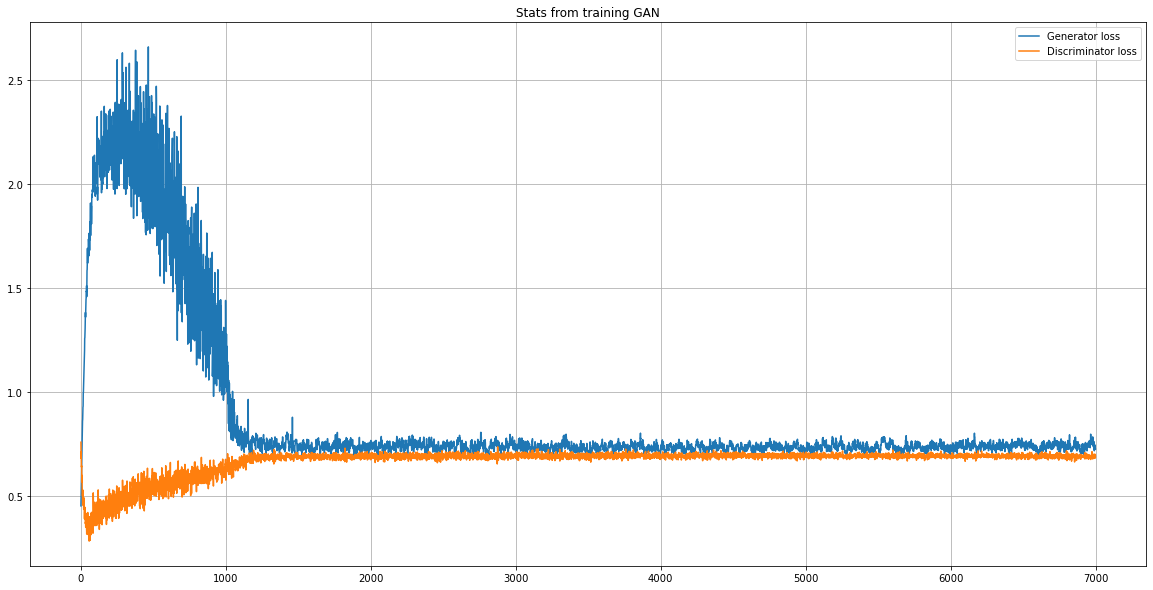

In [38]:
def define_complete_gan(generator, discriminator):  
    discriminator.trainable = False  
    gan_output = discriminator(generator.output)  
    
    #Initialize gan
    model = Model(inputs = generator.input, outputs = gan_output)  

    #Model Compilation
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.0002, beta_1=0.5))  
    return model  

completegan = define_complete_gan(generator, discriminator)  

def gan_train(gan, generator, discriminator, numerical, latent_dim, n_epochs, n_batch, n_eval):  
    #Upddte Discriminator with half batch size
    half_batch = int(n_batch / 2)  
    discriminator_loss = []  
    generator_loss = []  
    #generate class labels for fake and real
    valid = np.ones((half_batch, 1))  
    y_gan = np.ones((n_batch, 1))  
    fake = np.zeros((half_batch, 1))  

    #training
    for i in range(n_epochs):  
        #select random batch from real categorical and numerical data
        idx = np.random.randint(0, numerical.shape[0], half_batch)
        numerical_real = numerical_df_rescaled[idx]  

        #concatenate categorical and numerical data for the discriminator
        real_data = numerical_real
  
        #generate fake samples from the noise
        noise = np.random.normal(0, 1, (half_batch, latent_dim))  
        fake_data = generator.predict(noise)  
     
        #train the discriminator and return losses and acc
        d_loss_real, da_real = discriminator.train_on_batch(real_data, valid)  
        d_loss_fake, da_fake = discriminator.train_on_batch(fake_data, fake)  
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  
        discriminator_loss.append(d_loss)  
       
        #generate noise for generator input and train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (n_batch, latent_dim))  
        g_loss = gan.train_on_batch(noise, y_gan)  
        generator_loss.append(g_loss)  

        #evaluate progress
        if (i+1) % n_eval == 0:  
            print ("Epoch: %d [Discriminator loss: %f] [Generator loss: %f]" % (i + 1, d_loss, g_loss))  
            
    plt.figure(figsize = (20, 10))  
    plt.plot(generator_loss, label = "Generator loss")  
    plt.plot(discriminator_loss, label = "Discriminator loss")     
    plt.title("Stats from training GAN")  
    plt.grid()  
    plt.legend()  

latent_dim = 100  
gan_train(completegan, generator, discriminator, numerical_df_rescaled, latent_dim, n_epochs = 7000, n_batch = 63, n_eval = 200)

In [51]:
noise = np.random.normal(0, 1, (96, 100))  
generated_mixed_data = generator.predict(noise)  

In [53]:
original_data = numerical_df

<AxesSubplot:>

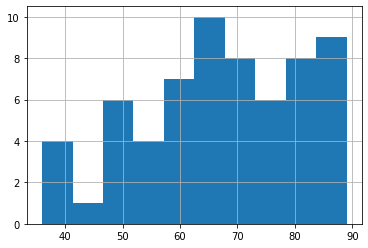

In [97]:
original_data['age'].hist()

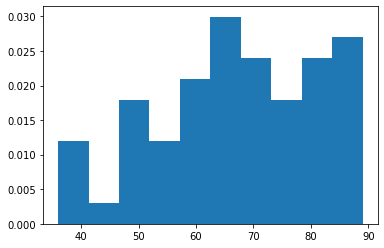

In [95]:
plt.hist(original_data['age'], density=True)
plt.show()

In [59]:
gen_df = pd.DataFrame(generated_mixed_data)

<AxesSubplot:>

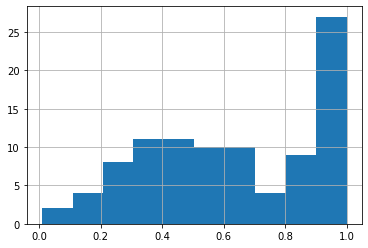

In [64]:
gen_df[0].hist()

In [98]:
import seaborn as sns

<AxesSubplot:xlabel='0', ylabel='Density'>

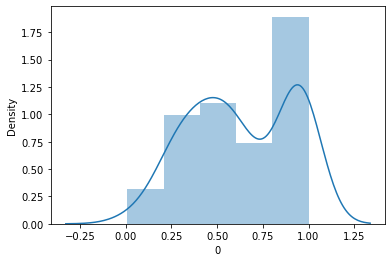

In [101]:
sns.distplot(gen_df[0])

<AxesSubplot:xlabel='age', ylabel='Density'>

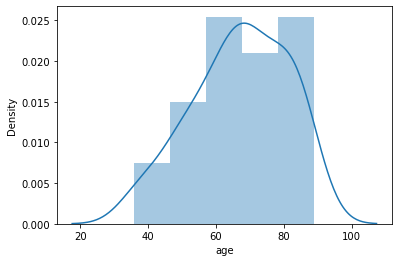

In [102]:
sns.distplot(original_data['age'])